In [138]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
import pymysql
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from statistics import stdev
from statistics import mean
from pandas.tseries.offsets import DateOffset
import mplfinance as mpf

api_key = 'QFZF2CEU5FAI6YIW'

In [139]:
sym = input("Input your stock ticker: ")

ts = TimeSeries(key= api_key, output_format = 'pandas')
df, meta_data = ts.get_daily(symbol = sym, outputsize = 'full')

# incorporate spy
ts = TimeSeries(key= api_key, output_format = 'pandas')
SPY, meta_data = ts.get_daily(symbol = 'SPY', outputsize = 'full')

SPY = SPY.drop(columns = ['1. open', '2. high', '3. low'])
df = pd.merge(df, SPY, on= 'date')

Input your stock ticker: GOOG


Given the 0 index begins at the most recent day, we must reverse index position in order to find the moving average.
Because the rolling average takes the earliest index positions to calculate the moving average for numbers ahead. 
I.E. index 0-49 calculate average for 50 we must reverse the dataframe to get the average for most recent days. 

In [140]:
df.reset_index(inplace = True)
df.rename(columns = {'date': 'Date','1. open' : 'Open', '2. high': 'High', '3. low': 'Low', '4. close_x': 'Close', '5. volume_x': 'Volume', '4. close_y': 'SPYClose', '5. volume_y': 'SPYVolume'}, inplace = True)

# reverse
df = df.reindex(index = df.index[::-1])
df.reset_index(inplace = True, drop = True)


def percentage_change(High, Low):
    return(High - Low)

# Create 50 EMA column, and day of the week column 
df['50ema'] = df['Close'].rolling(window = 50).mean()
df['200ema'] = df['Close'].rolling(window = 200).mean()
df['DayOfWeek'] = df['Date'].dt.day_name()
df['PctChange'] = df['Close'].pct_change()*100
df['HLVolatility'] = percentage_change(df['High'], df['Low'])
df['GainLoss'] = df['PctChange']/100*df['Close']




# reverse back, and assign column in specific order
spec_order = ['GainLoss', 'DayOfWeek', 'Date', 'Open', 'Close', 'PctChange','High', 'Low','HLVolatility','50ema', '200ema', 'Volume', 'SPYVolume', 'SPYClose']
df = df.reindex(index = df.index[::-1], columns = spec_order)
df.reset_index(inplace = True, drop = True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
stock_df = df.copy()
df

GainLoss  DayOfWeek       Date    Open   Close  PctChange    High  \
0        -0.28  Wednesday 2021-11-17 2984.58 2981.24      -0.01 2992.52   
1        -6.23    Tuesday 2021-11-16 2983.41 2981.52      -0.21 2996.65   
2        -5.14     Monday 2021-11-15 3000.00 2987.76      -0.17 3009.54   
3        59.09     Friday 2021-11-12 2956.63 2992.91       1.97 2997.19   
4         2.44   Thursday 2021-11-11 2942.14 2934.96       0.08 2970.05   
...        ...        ...        ...     ...     ...        ...     ...   
1922     -0.16  Wednesday 2014-04-02  565.11  567.00      -0.03  604.83   
1923     10.38    Tuesday 2014-04-01  558.71  567.16       1.83  568.45   
1924     -3.00     Monday 2014-03-31  566.89  556.97      -0.54  567.00   
1925      1.53     Friday 2014-03-28  561.20  559.99       0.27  566.43   
1926       NaN   Thursday 2014-03-27  568.00  558.46        NaN  568.00   

         Low  HLVolatility   50ema  200ema    Volume    SPYVolume  SPYClose  
0    2971.26         21.26 2850.88 2524.39 764541.00  47858289.00    468.14  
1    2967.00         29.65 2849.21 2519.83 862743.00  48857502.00    469.28  
2    2973.05         36.49 2847.79 2514.56 812367.00  46980500.00    467.43  
3    2929.08         68.11 2845.94 2509.13 849970.00  51018081.00    467.27  
4    2933.89         36.16 2843.77 2503.35 623155.00  34848495.00    463.77  
...      ...           ...     ...     ...       ...          ...       ...  
1922  562.19         42.64     NaN     NaN 146700.00  78680761.00    188.88  
1923  558.71          9.74     NaN     NaN   7900.00  89193125.00    188.25  
1924  556.93         10.07     NaN     NaN  10800.00  99744911.00    187.01  
1925  558.67          7.76     NaN     NaN  41100.00 101641547.00    185.49  
1926  552.92         15.08     NaN     NaN  13100.00 142382757.00    184.58  

[1927 rows x 14 columns]

In [ ]:
d = df.groupby(df['Date'].dt.to_period('M')).agg('sum').reset_index()
d['Date'] = d['Date'].apply(str)


January = d[d['Date'].str.endswith('01')].set_index('Date')
February = d[d['Date'].str.endswith('02')].set_index('Date')
March = d[d['Date'].str.endswith('03')].set_index('Date')
April = d[d['Date'].str.endswith('04')].set_index('Date')
May = d[d['Date'].str.endswith('05')].set_index('Date')
June = d[d['Date'].str.endswith('06')].set_index('Date')
July = d[d['Date'].str.endswith('07')].set_index('Date')
August = d[d['Date'].str.endswith('08')].set_index('Date')
September = d[d['Date'].str.endswith('09')].set_index('Date')
October = d[d['Date'].str.endswith('10')].set_index('Date')
November = d[d['Date'].str.endswith('11')].set_index('Date')
December = d[d['Date'].str.endswith('12')].set_index('Date')

def check(frame):
    k = 0
    count = 0
    for num in frame['PctChange']:
        if num > k:
            count += 1
    x = round(count/len(frame['PctChange']),2)
    return(x, '+')

In [ ]:
frames = [January, February, March, April, May, June, July, August, September, October, November, December]


def graphs(month):
    month['PctChange'].plot(kind = 'barh', figsize = (12, 10))
    plt.title(check(month))
    plt.axvline(x = 0, color = '.5')
    plt.subplots_adjust(left = 0.3)

plt.subplot(3,4,1)   
graphs(January)
plt.subplot(3,4,2)
graphs(February)
plt.subplot(3,4,3)
graphs(March)
plt.subplot(3,4,4)
graphs(April)
plt.subplot(3,4,5)
graphs(May)
plt.subplot(3,4,6)
graphs(June)
plt.subplot(3,4,7)
graphs(July)
plt.subplot(3,4,8)
graphs(August)
plt.subplot(3,4,9)
graphs(September)
plt.subplot(3,4,10)
graphs(October)
plt.subplot(3,4,11)
graphs(November)
plt.subplot(3,4,12)
graphs(December)
plt.subplots_adjust(left=0.01,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.99, 
                    hspace=0.34)


print(sym, 'Plots by Monthly % Change ')

In [ ]:
question = input("Would you like to search within a certain range date? Y/N " )

# for ans in question:
for ans in question:
    if ans == 'Y':
        year_begin = input("What is your start date in YYYY-MM-DD format : ")
        date_time_obj = datetime.strptime(year_begin, '%Y-%m-%d')
        year_end = input("What is your end date in YYYY-MM-DD format : ")
        date_time_obj_2 = datetime.strptime(year_end, '%Y-%m-%d')
    else:
        pass


    
month_dict = {
    "january" : 1,
    "february" : 2,
    "march" : 3,
    "april" : 4,
    "may" : 5,
    "june" : 6,
    "july" : 7,
    "august" : 8,
    "september" : 9,
    "october" : 10,
    "november" : 11,
    "december" : 12
}

n = input('Enter a month to analyze ').lower()

month = (month_dict[n])


if ans == 'Y':
    df = df[(df['Date'] > (date_time_obj)) & (df['Date'] < (date_time_obj_2))]
else:
    pass

oo = df[df['Date'].dt.month == month]

In [ ]:
# group by given month day of the week. 

o = oo.groupby(['DayOfWeek'])

one = o['PctChange'].agg(['median', 'mean'])
two = o['GainLoss'].agg(['median', 'mean'])
three = o['HLVolatility'].agg(['median', 'mean'])
four = o['Volume'].agg(['median', 'mean'])

df_ = pd.concat([one, two, three, four], axis = 1)


# function taken from stack overflow to give columns name in order to ultimately rename
# https://stackoverflow.com/questions/24685012/pandas-dataframe-renaming-multiple-identically-named-columns (MaxU)

cols=pd.Series(df_.columns)
for dup in df_.columns[df_.columns.duplicated(keep=False)]: 
    cols[df_.columns.get_loc(dup)] = ([dup + '.' + str(d_idx) 
                                     if d_idx != 0 
                                     else dup 
                                     for d_idx in range(df_.columns.get_loc(dup).sum())]
                                    )
df_.columns=cols
df_.rename(columns = {'median':'%_Change_Median', 'mean': '%_Change_Mean', 'median.1': 'Gain_Loss_Median', 'mean.1': 'Gain_Loss_Mean', 'median.2': 'Volatility$_Range_Median', 'mean.2': 'Volatility$_Range_Mean', 'mean.3': 'Volume_Mean', 'median.3': 'Volume_Median'}, inplace = True)
df_ = df_.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])


# ---------
# grouping specific time range of data by day, and storing in df variable. 

day_group = df.groupby(['DayOfWeek'])

DG_Daily_Change = day_group['PctChange'].agg(['median', 'mean'])
DG_Gain_Loss = day_group['GainLoss'].agg(['median', 'mean'])
DG_Volatility = day_group['HLVolatility'].agg(['median', 'mean'])
DG_Volume = day_group['Volume'].agg(['median', 'mean'])

pd.set_option('display.float_format', lambda x: '%.2f' % x)


df = pd.concat([DG_Daily_Change, DG_Gain_Loss, DG_Volatility, DG_Volume], axis = 1)

# function taken from stack overflow to give columns name in order to ultimately rename
# put link in from overflow, if adpated state it 
cols=pd.Series(df.columns)
for dup in df.columns[df.columns.duplicated(keep=False)]: 
    cols[df.columns.get_loc(dup)] = ([dup + '.' + str(d_idx) 
                                     if d_idx != 0 
                                     else dup 
                                     for d_idx in range(df.columns.get_loc(dup).sum())]
                                    )
df.columns=cols

df.rename(columns = {'median':'%_Change_Median', 'mean': '%_Change_Mean', 'mean.1': 'Gain_Loss_Mean', 'median.1': 'Gain_Loss_Median' , 'median.2': 'Volatility$_Range_Median', 'mean.2': 'Volatility$_Range_Mean', 'median.3': 'Volume_Median', 'mean.3': 'Volume_Mean'}, inplace = True)
df = df.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

comparison = pd.concat([df, df_], keys = ['All Time', n])

# Graphical Representation of Volatility

In [ ]:
x = comparison.reset_index()
x.plot.bar(x = 'DayOfWeek', y='Volatility$_Range_Mean', color = ['black', 'red', 'blue', 'green', 'cyan'], legend = False)
plt.axvline(x = 4.5)
plt.text(2.0, 2.2, 'All Time', size = 15)
plt.text(5.8, 2.2, n, size = 15)
plt.ylabel('Dollar Range', fontsize = 15)
plt.xlabel('Day of the Week', fontsize = 15)
plt.title(sym+ ' Average Volatility Dollar Range', fontsize = 15);

# Intraday Timestamp Lows and Highs

In [ ]:
df_low = pd.read_csv(sym + '_low_intraday.csv')
df_low.drop_duplicates(inplace = True)
df_low.drop([1], inplace = True)
df_low['DayOfWeek'] = df_low['Day_of_the_Week'].str.upper()


day = input('Type in the specific day to filter : ').upper()

day_filt = df_low['DayOfWeek'] == day
spec_day = df_low.loc[day_filt]

spec_day = spec_day.drop(labels = ['open', 'high', 'low', 'close', 'volume'], axis = 1)


sauce = []
times = []

for stuff in spec_day['time']:
    sauce.append(stuff)
    for stuff in sauce:
            times.append(stuff[11:16])
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

spec_day = pd.DataFrame(new_alter)

spec_day.plot.hist(bins = 44, legend = False)

fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)


plt.xlabel(day + ' TIMESTAMPS (Past 4 Months)', fontsize = 25)
plt.ylabel('FREQUENCY', fontsize = 25)
plt.title(sym + ' LOW Price Per Day by TIMESTAMPS', fontsize = 25)



def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = spec_day.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]
    
get_standard(spec_day)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');
    

In [ ]:
sauce = []
times = []

for stuff in df_low['time']:
    sauce.append(stuff)
    for stuff in sauce:
            times.append(stuff[11:16])
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

df_low = pd.DataFrame(new_alter)


df_low.plot.hist(bins = 44, legend = False)

fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)

plt.xlabel('M-F TIMESTAMPS (Past 4 Months)', fontsize = 25)
plt.ylabel('FREQUENCY', fontsize = 25)
plt.title(sym +' LOW Price Per Day by TIMESTAMPS', fontsize = 25)

# -------------------

def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = df_low.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]
    
get_standard(df_low)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');

In [ ]:
df_high = pd.read_csv(sym + '_high_intraday.csv')
df_high.drop_duplicates(inplace = True)
df_high.drop([1], inplace = True)
df_high['DayOfWeek'] = df_high['Day_of_the_Week'].str.upper()



day_filt = df_high['DayOfWeek'] == day
spec_day = df_high.loc[day_filt]

spec_day = spec_day.drop(labels = ['open', 'high', 'low', 'close', 'volume'], axis = 1)


sauce = []
times = []

for stuff in spec_day['time']:
    sauce.append(stuff)
    for stuff in sauce:
            times.append(stuff[11:16])
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

spec_day = pd.DataFrame(new_alter)


spec_day.plot.hist(bins = 44, legend = False)

fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)


plt.xlabel(day + ' TIMESTAMPS (Past 4 Months)', fontsize = 25)
plt.ylabel('FREQUENCY', fontsize = 25)
plt.title(sym + ' HIGH Price Per Day by TIMESTAMPS', fontsize = 25);

# ---------------

def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = spec_day.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]
    
get_standard(spec_day)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');


In [ ]:


sauce = []
times = []

for stuff in df_high['time']:
    sauce.append(stuff)
    for stuff in sauce:
            times.append(stuff[11:16])
            
altered = ([s.replace(':', '') for s in times])
new_alter = [int(i) for i in altered]

df_high = pd.DataFrame(new_alter)


df_high.plot.hist(bins = 44, legend = False)

fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)

plt.xlabel('M-F TIMESTAMPS (Past 4 Months)', fontsize = 25)
plt.ylabel('FREQUENCY', fontsize = 25)
plt.title(sym +' HIGH Price Per Day by TIMESTAMPS', fontsize = 25);

# -----

def get_standard(df_col):
    std = stdev(df_col[0])
    mn = mean(df_col[0])
    upper_68 = round(mn+std)
    lower_68 = mn-std
    mx = df_high.value_counts().max()
    global xcoordz
    xcoordz = [upper_68, lower_68, mx]
    
get_standard(df_high)


for xc in xcoordz:
    plt.axvline(x = xcoordz[0], color = 'k', linestyle = '--')
    plt.axvline(x = xcoordz[1], color = 'k', linestyle = '--')
    plt.plot((xcoordz[0], xcoordz[1]), (xcoordz[2], xcoordz[2]), linestyle = '--', color = 'k');


# Graphical Representation of Stock % Change

In [ ]:

x.plot.bar(x = 'DayOfWeek', y='%_Change_Mean', color = ['black', 'red', 'blue', 'green', 'cyan'], legend = False)
plt.axvline(x = 4.5)
plt.text(.2,.1, 'All Time', size = 15)
plt.text( 5.2, .1, n, size = 15)
plt.ylabel('Pct_Change', fontsize = 15)
plt.xlabel('Day of the Week', fontsize = 15)
plt.title(sym + ' Stock % Change', fontsize = 15);

# Graphical Representation of Dollar Gain Loss

In [ ]:
x.plot.bar(x = 'DayOfWeek', y='Gain_Loss_Mean', color = ['black', 'red', 'blue', 'green', 'cyan'], legend = False)
plt.axvline(x = 4.5)
plt.text(.2,.1, 'All Time', size = 15)
plt.text( 5.2, .1, n, size = 15)
plt.ylabel('$ Gain Loss', fontsize = 15)
plt.xlabel('Day of the Week', fontsize = 15)
plt.title(sym + ' Stock $ Change', fontsize = 15);

# Historical Drops and Jumps

In [170]:
big_loss = stock_df.loc[stock_df['PctChange'] > 1.9]

todays_pct_change = round(stock_df['PctChange'].iloc[0],2)
print("Todays Percentage Change: " + str(todays_pct_change))

bl_list = big_loss['Date'].to_list()
print('\n'+str(len(bl_list))+ ' total records on account')

Todays Percentage Change: -0.01

157 total records on account


Historical Big Drops
2021-11-12


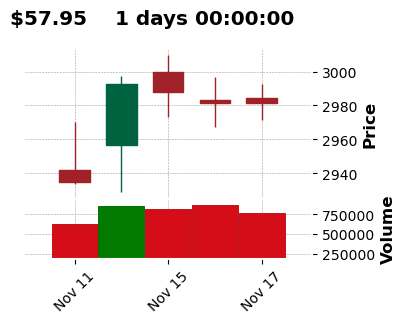

2021-10-27


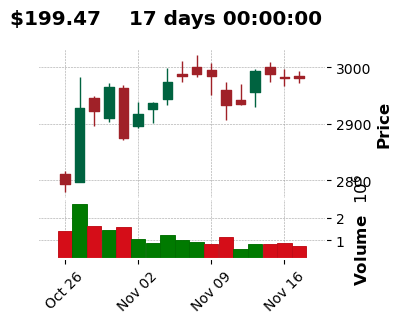

2021-10-14


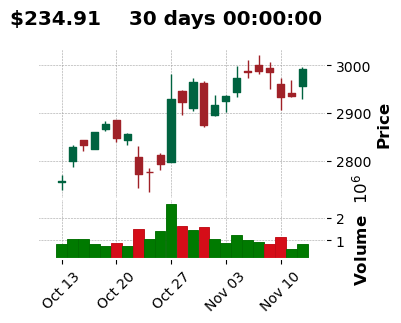

2021-10-01


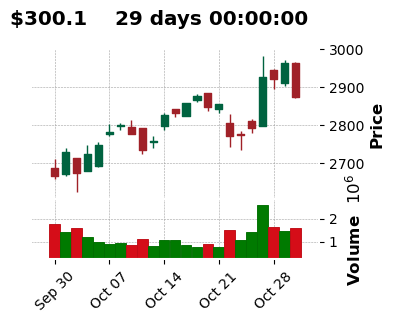

2021-08-23


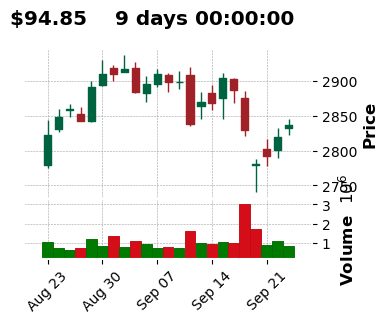

2021-07-23


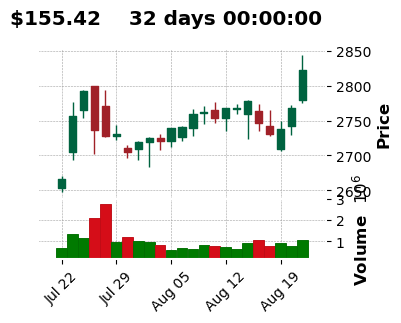

2021-06-04


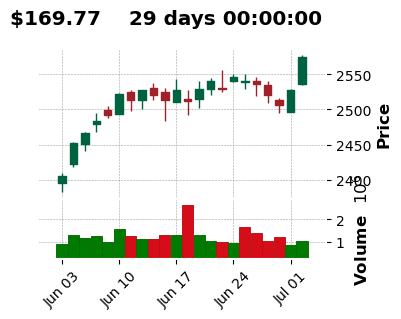

2021-05-24


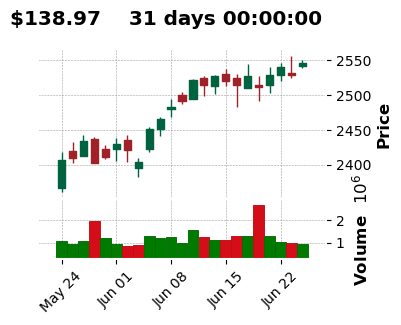

2021-05-20


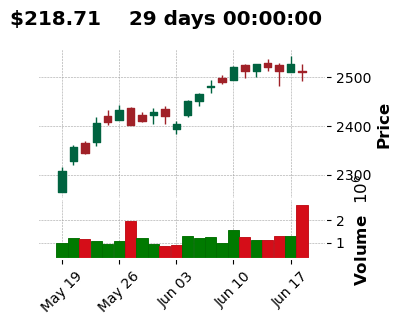

2021-05-14


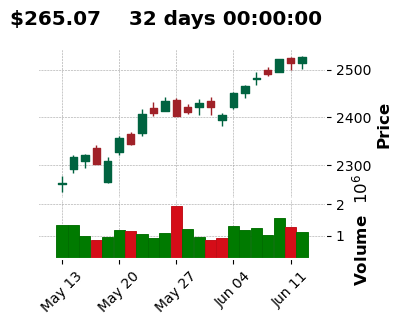

2021-04-29


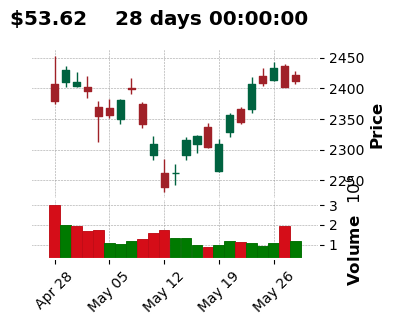

2021-04-28


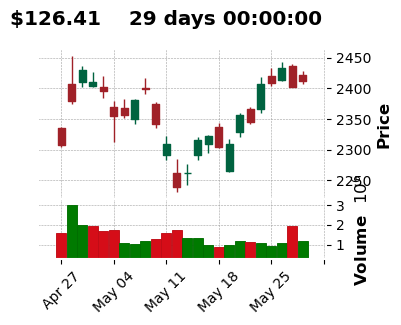

2021-04-23


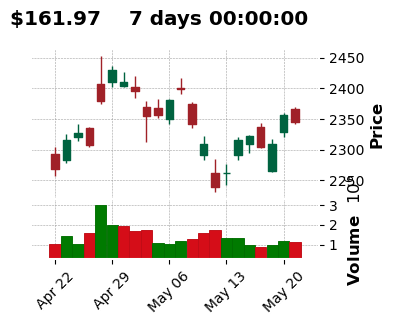

2021-04-05


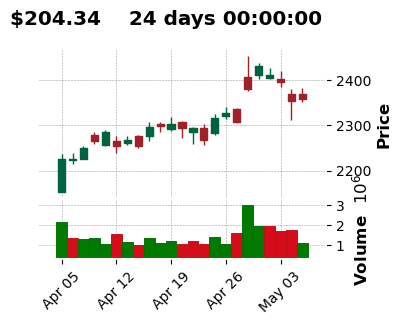

2021-04-01


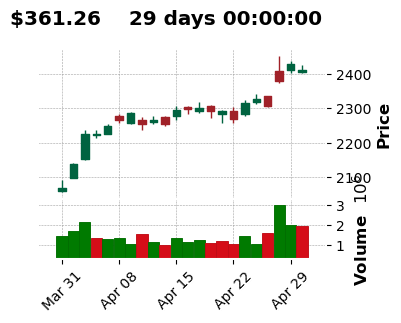

2021-03-11


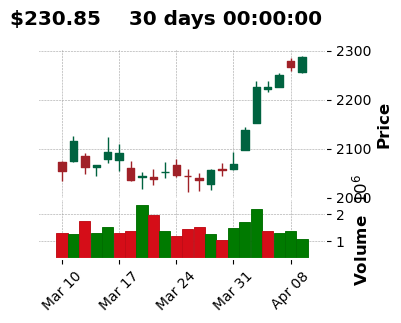

2021-03-05


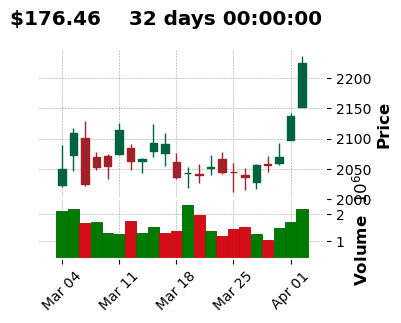

2021-03-01


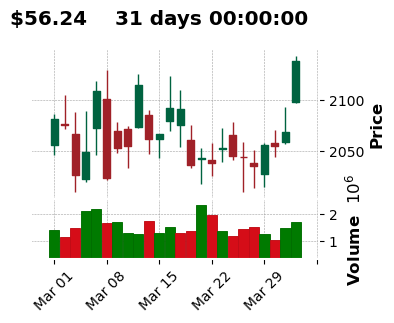

2021-02-03


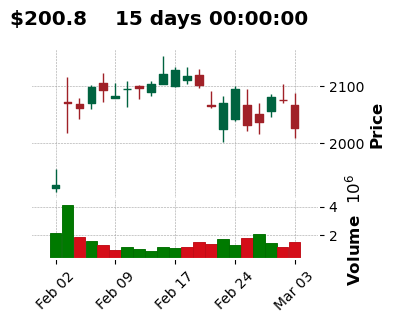

2021-02-01


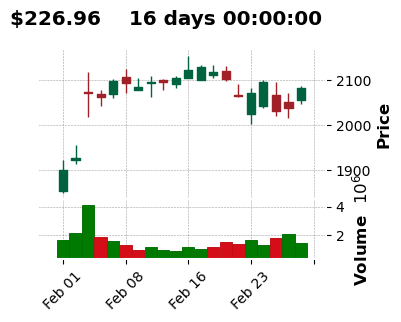

2021-01-20


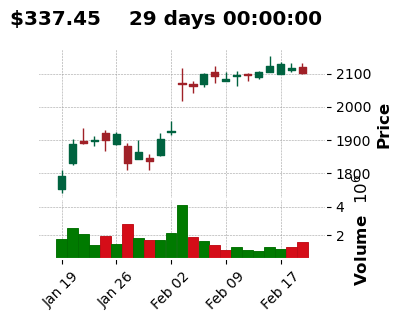

2021-01-19


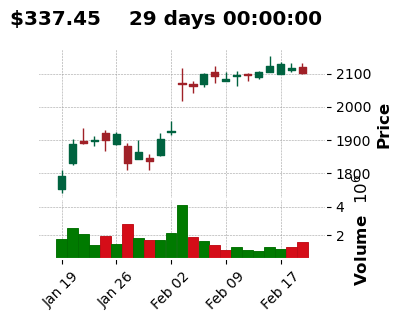

2021-01-07


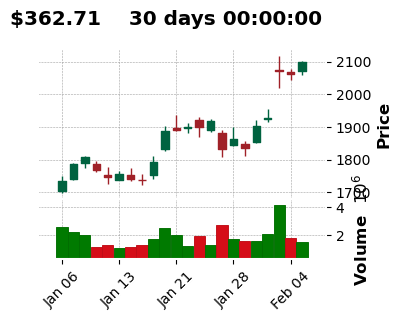

2020-12-28


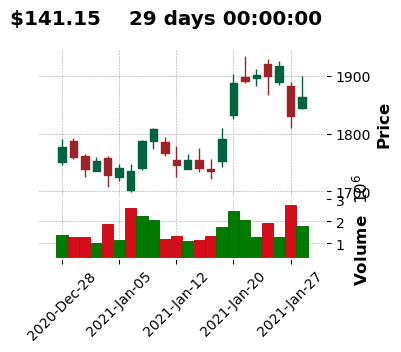

2020-12-01


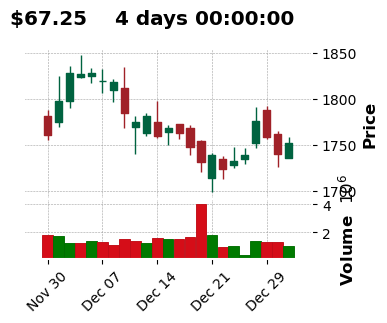

2020-11-24


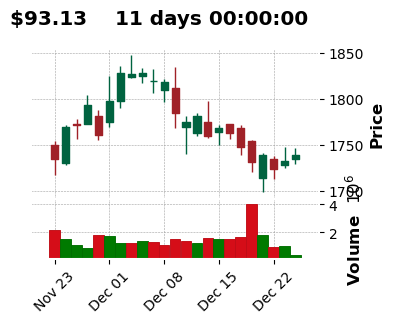

2020-11-04


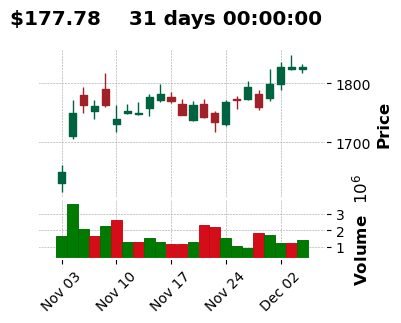

2020-10-30


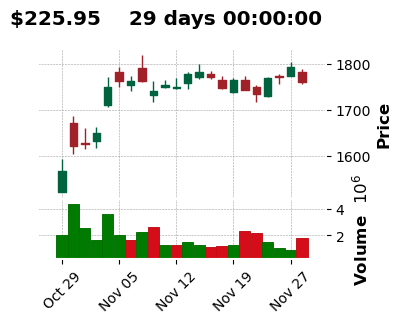

2020-10-29


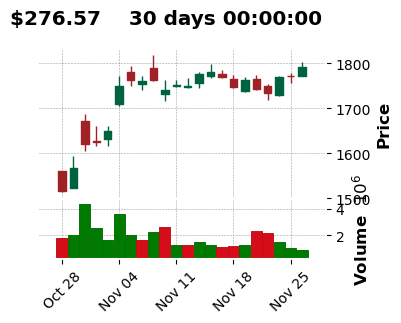

2020-10-21


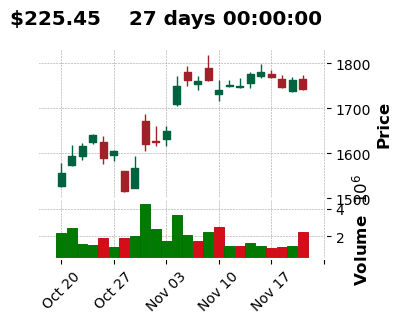

2020-10-12


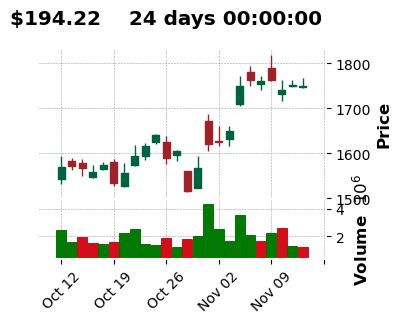

2020-10-09


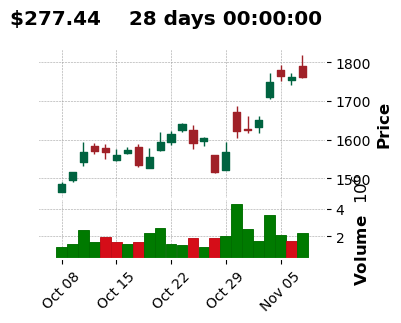

2020-09-22


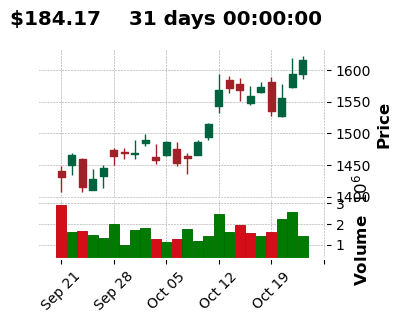

2020-09-02


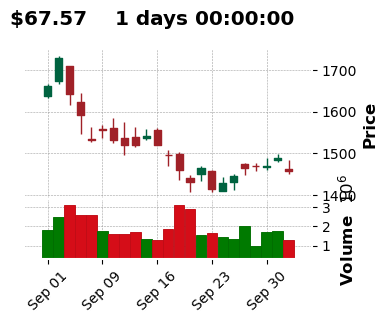

2020-08-26


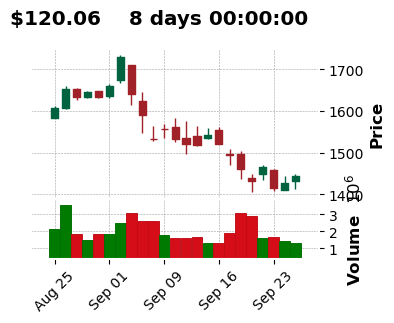

2020-08-20


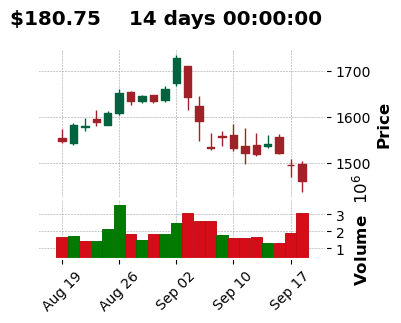

2020-08-18


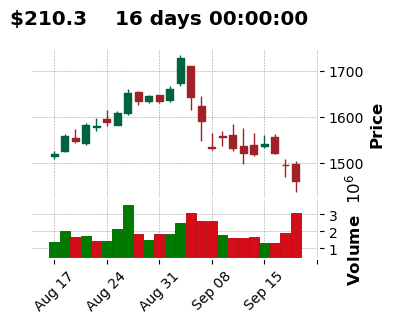

2020-07-20


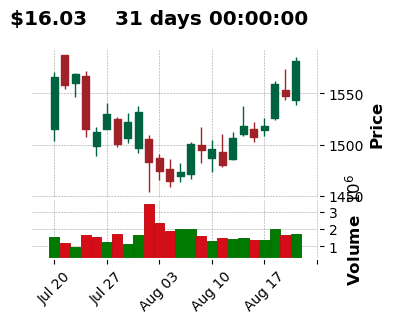

2020-07-10


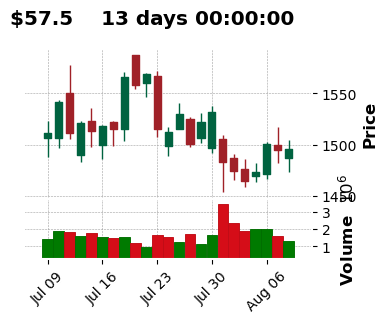

2020-07-06


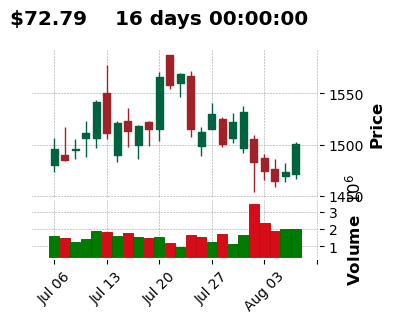

2020-06-29


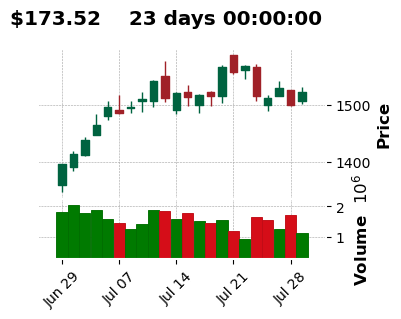

2020-05-20


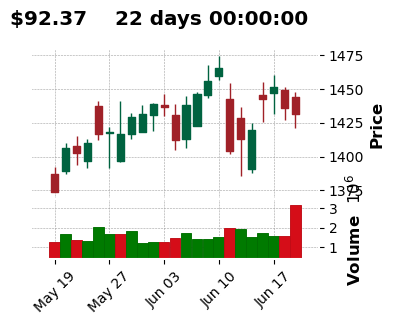

2020-04-29


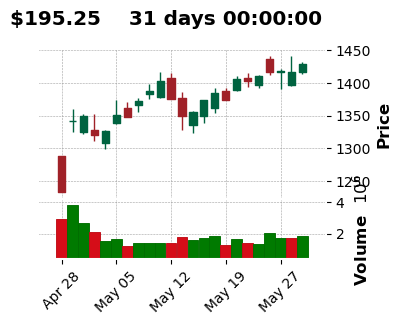

2020-04-22


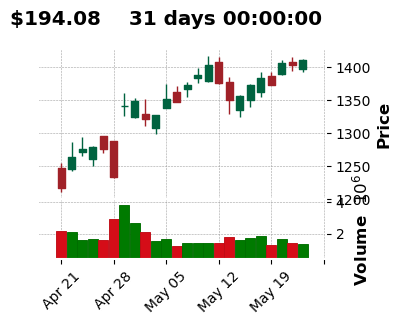

2020-04-14


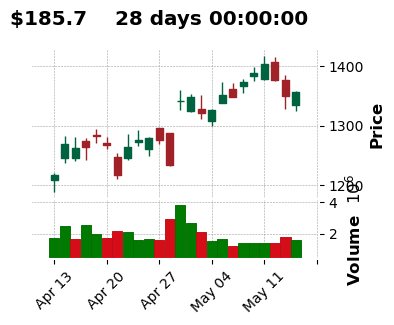

2020-04-08


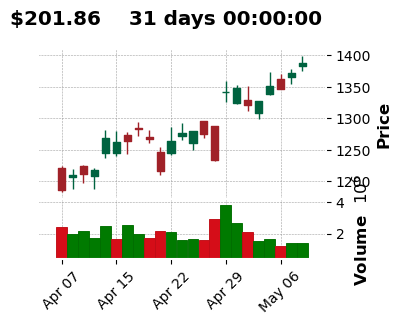

2020-04-06


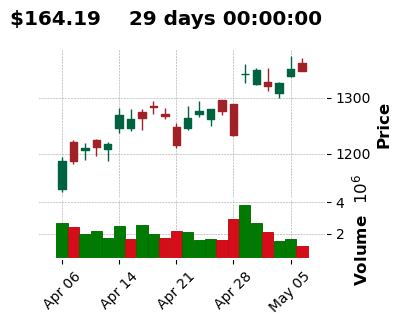

2020-03-30


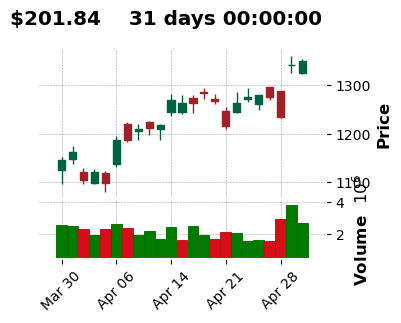

2020-03-26


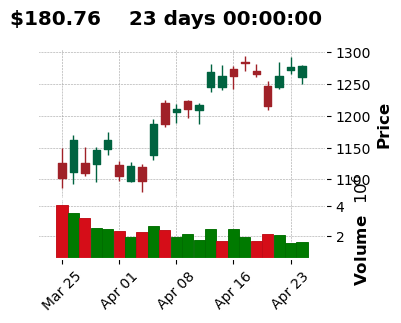

2020-03-24


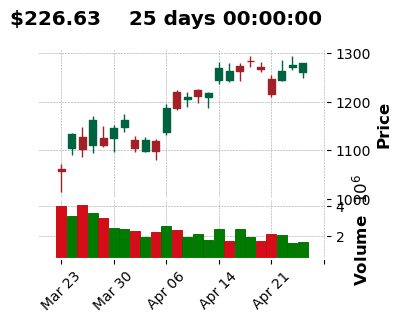

2020-03-17


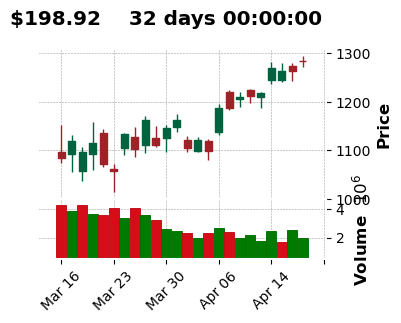

2020-03-13


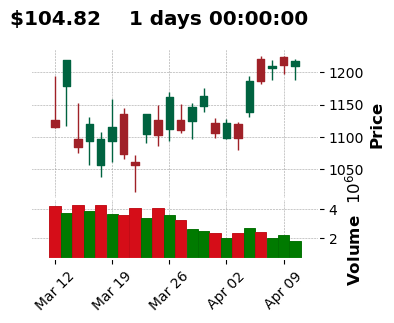

2020-03-10


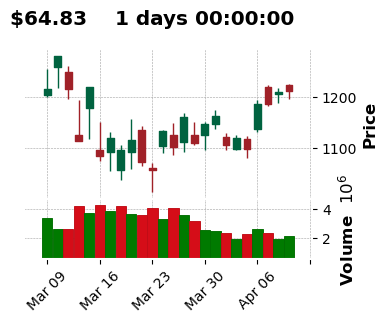

2020-03-04


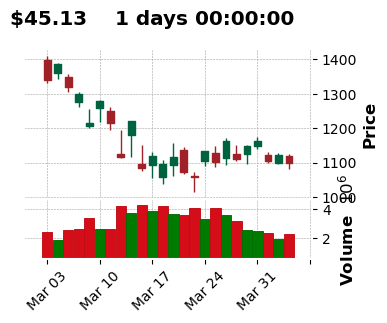

2020-03-02


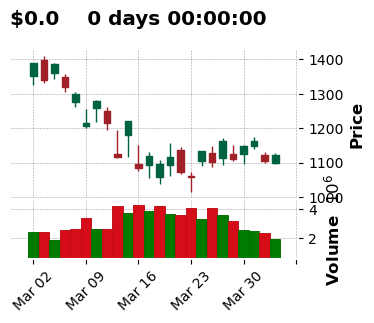

2020-02-10


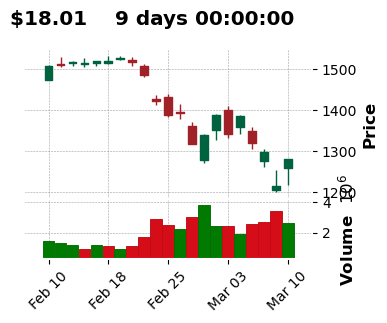

2020-02-06


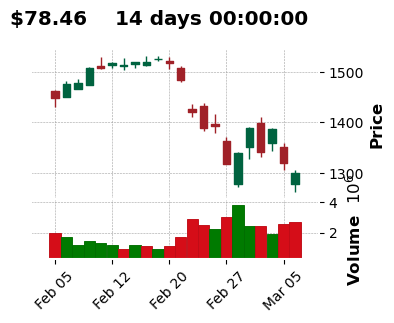

2020-02-03


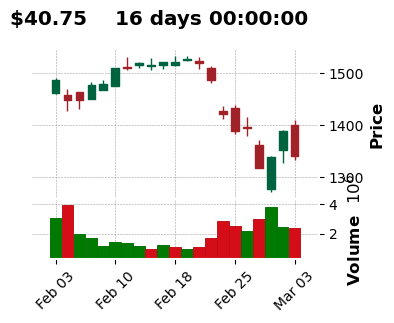

2020-01-17


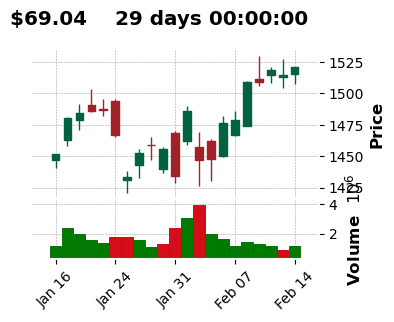

2020-01-06


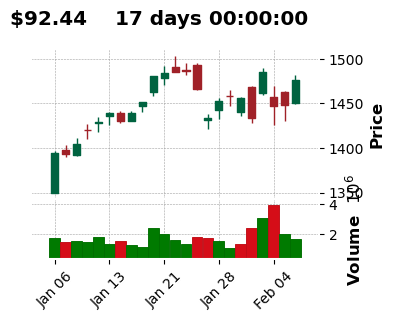

2020-01-02


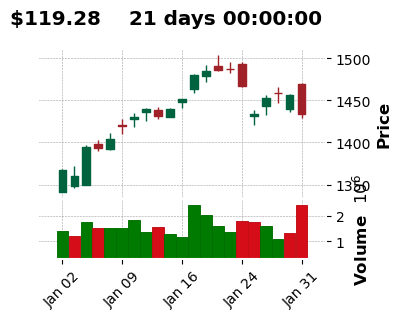

2019-12-04


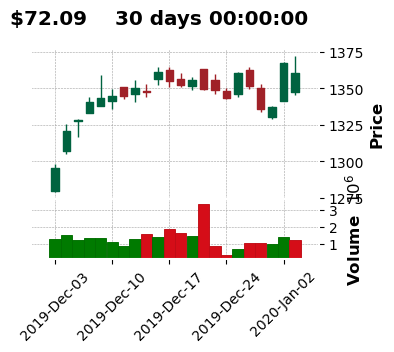

2019-10-28


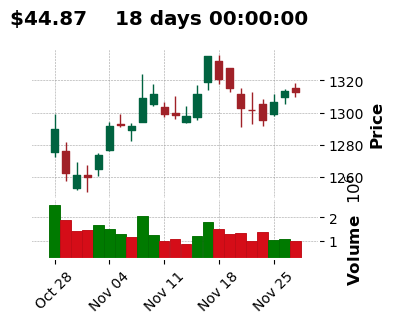

2019-10-15


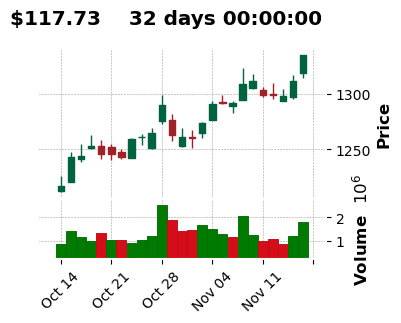

2019-09-25


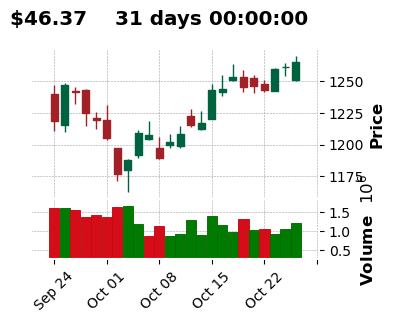

2019-09-05


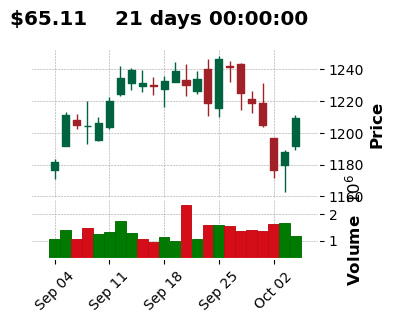

2019-08-13


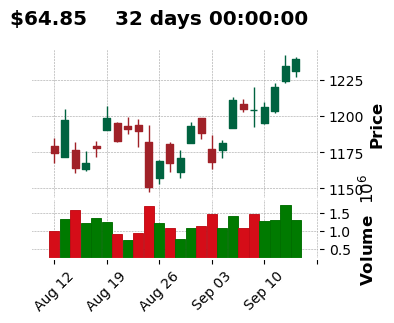

2019-08-08


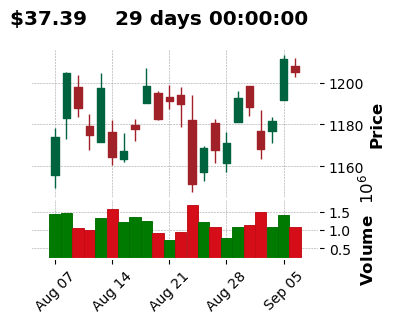

2019-07-26


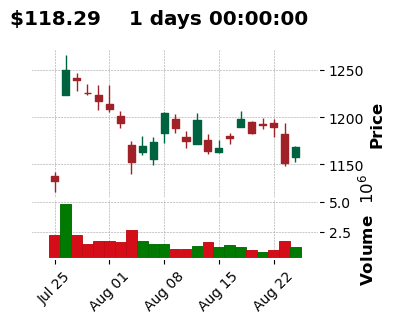

2019-06-07


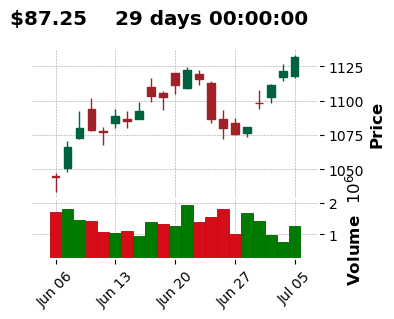

2019-05-15


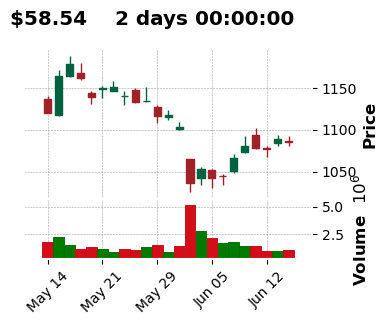

2019-05-03


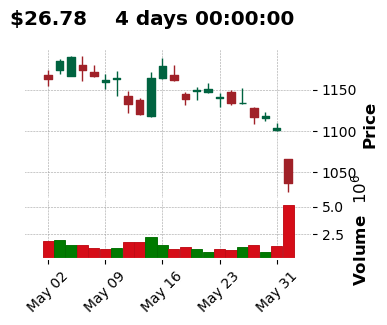

2019-03-20


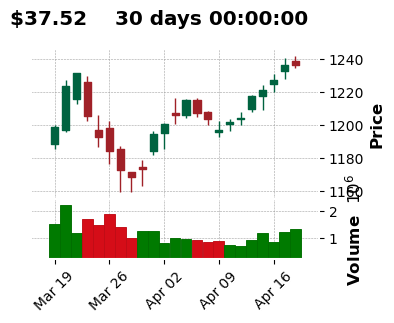

2019-03-11


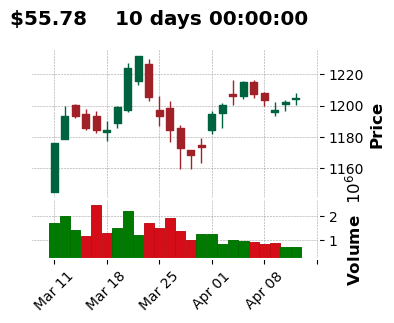

2019-02-12


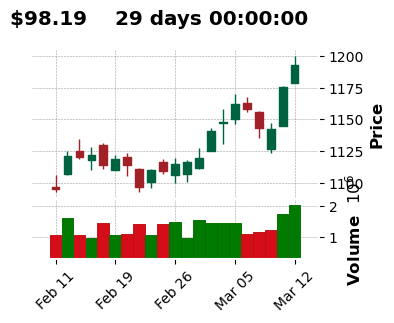

2019-02-04


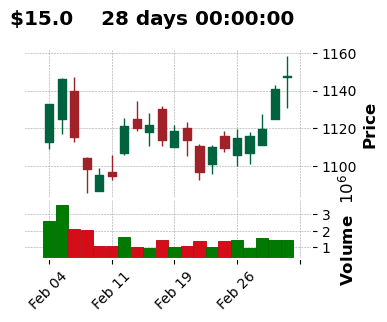

2019-01-31


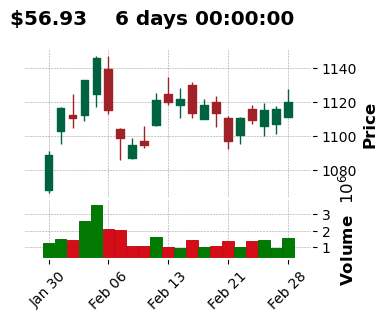

2019-01-30


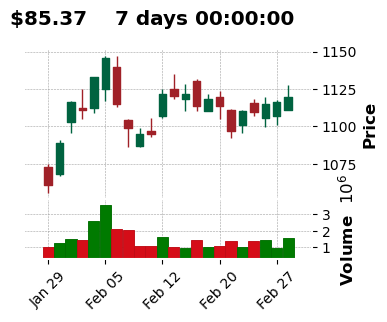

2019-01-15


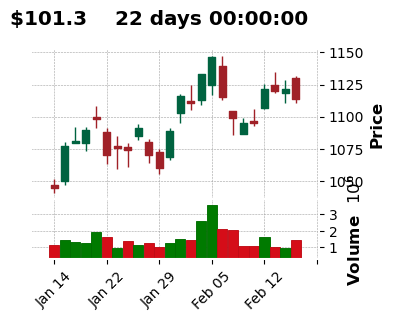

2019-01-04


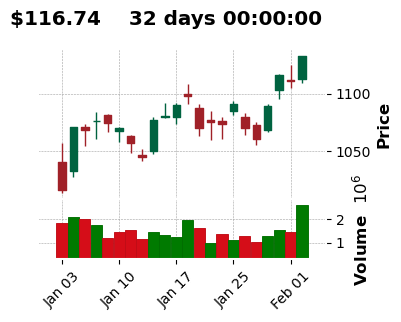

2018-12-26


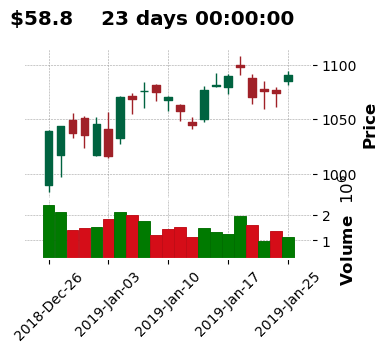

2018-11-28


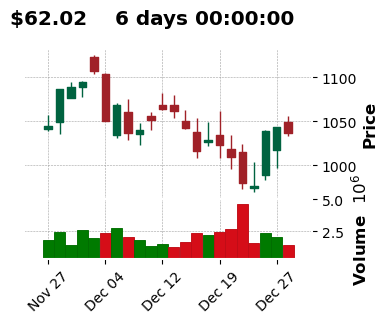

2018-11-26


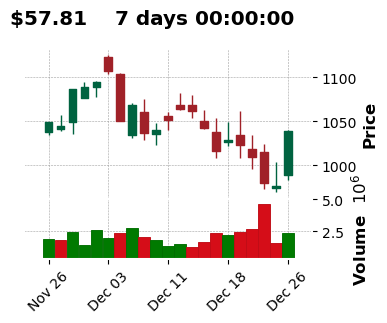

2018-11-15


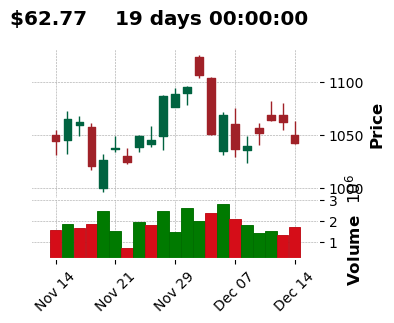

2018-11-07


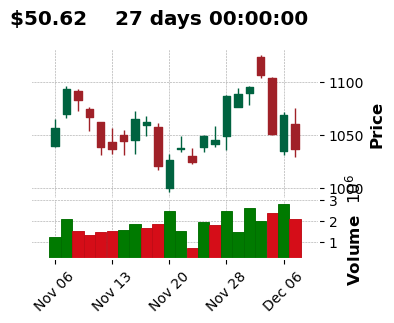

2018-10-31


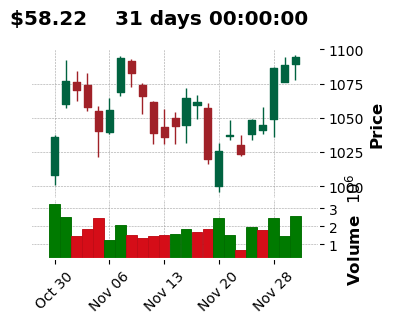

2018-10-25


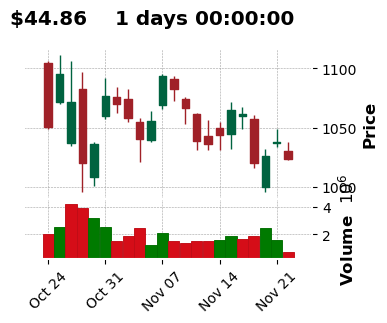

2018-10-16


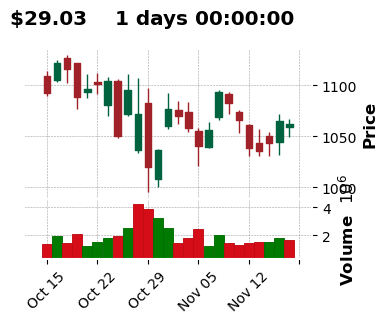

2018-10-12


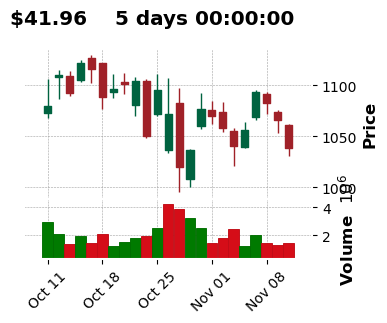

2018-07-24


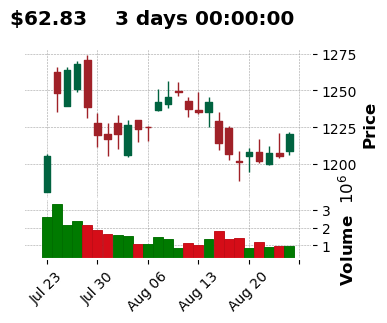

2018-07-12


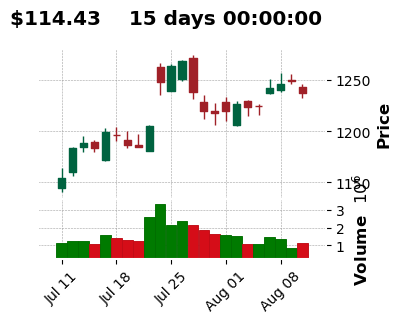

2018-07-05


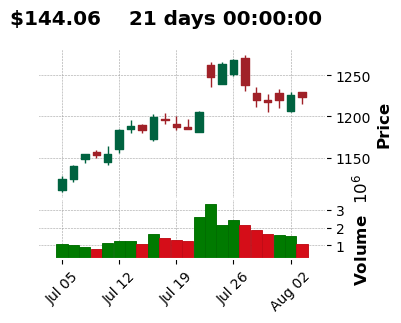

2018-06-01


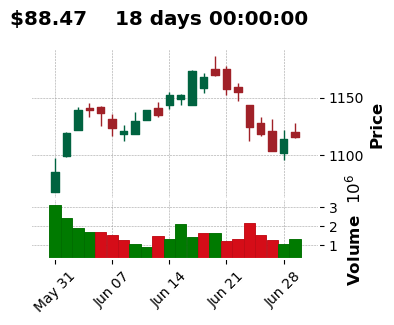

2018-05-09


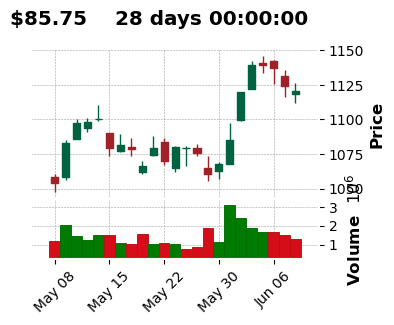

2018-05-04


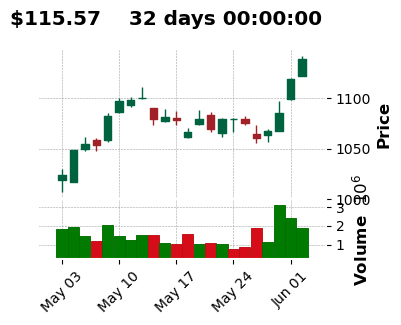

2018-05-01


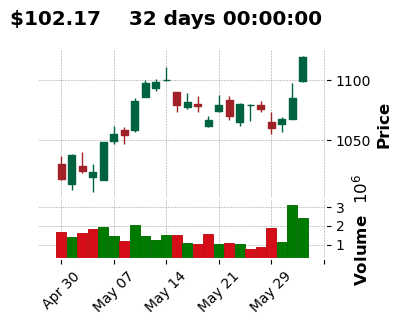

2018-04-17


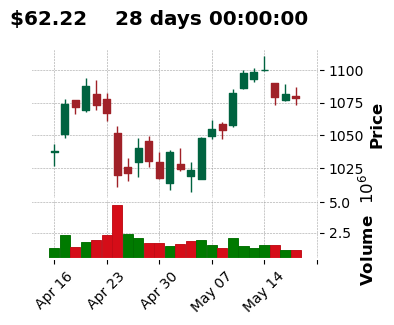

2018-03-29


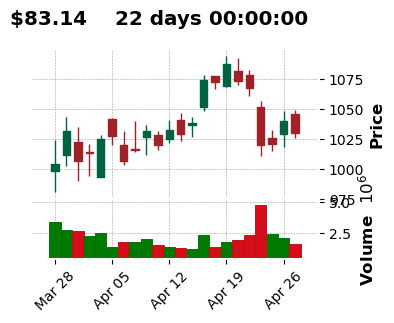

2018-03-26


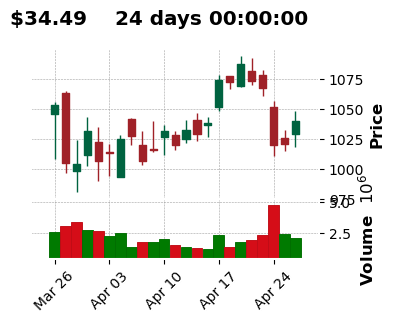

2018-03-09


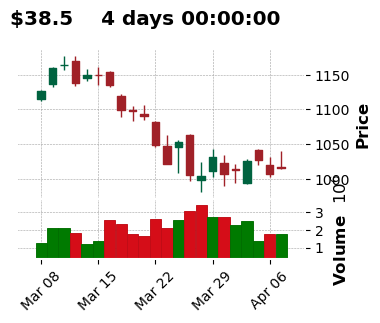

2018-02-09


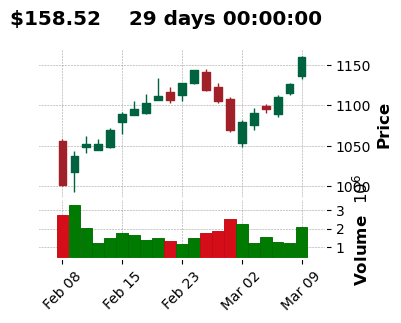

2018-02-06


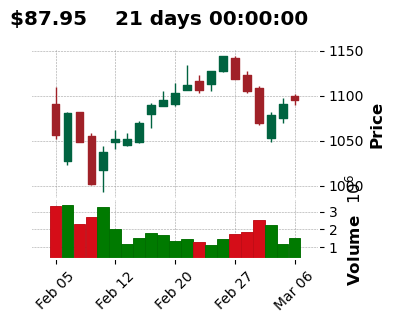

2017-10-27


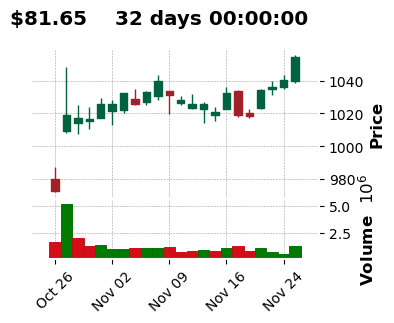

2017-10-05


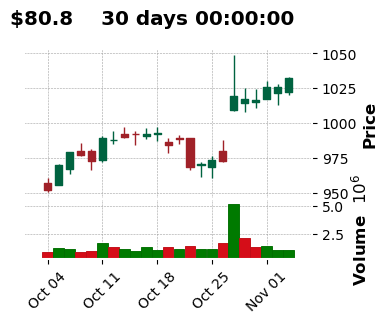

2017-09-27


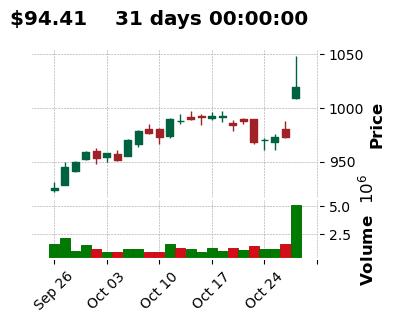

2017-08-22


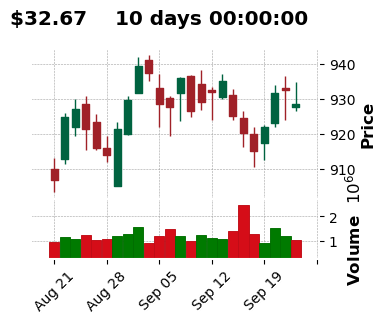

2017-04-28


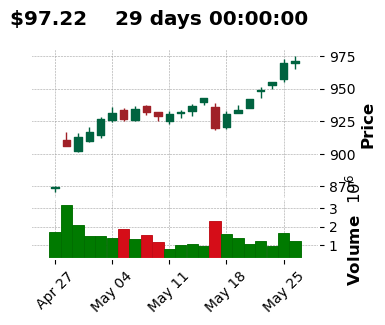

2017-04-24


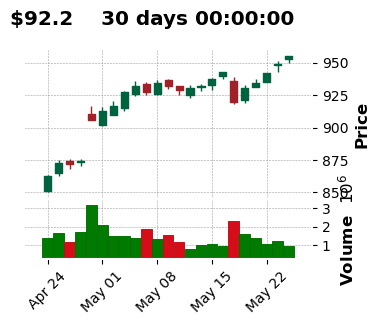

2016-11-15


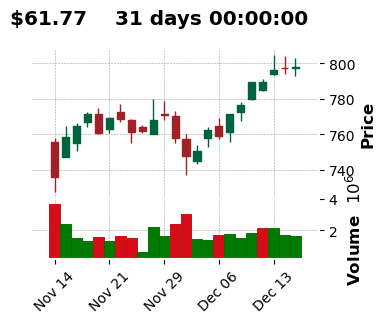

2016-11-07


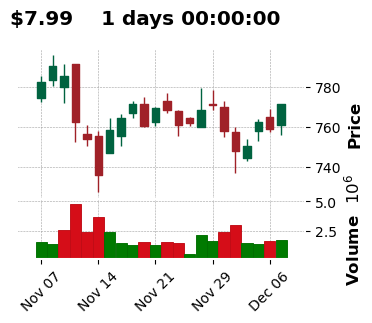

2016-10-18


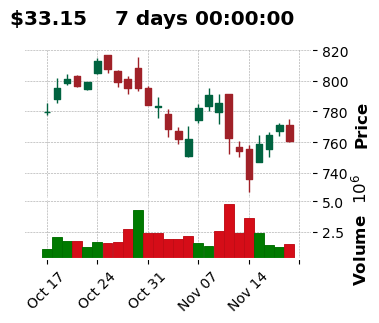

2016-07-29


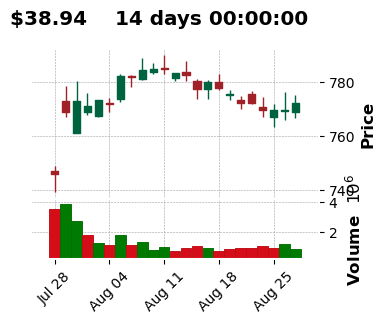

2016-07-18


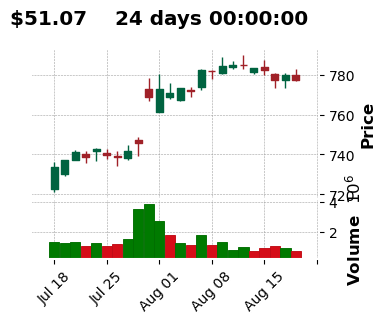

2016-05-24


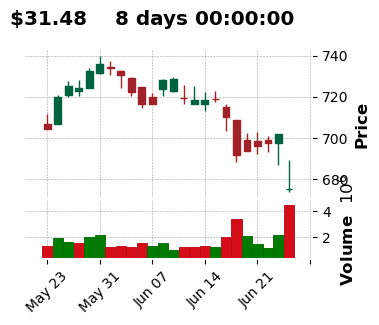

2016-03-11


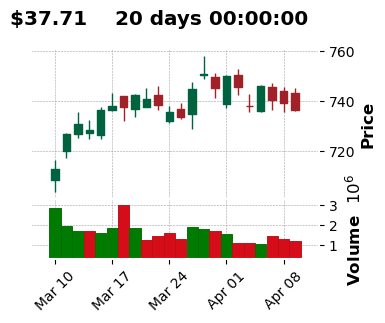

2016-03-01


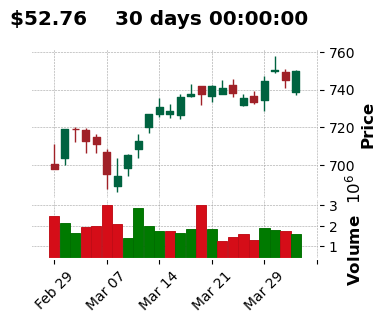

2016-02-17


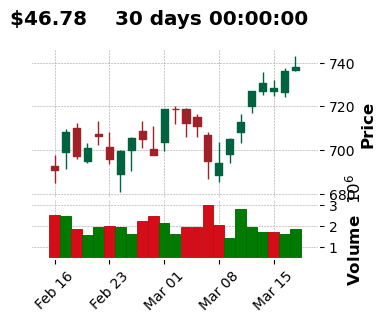

2016-01-28


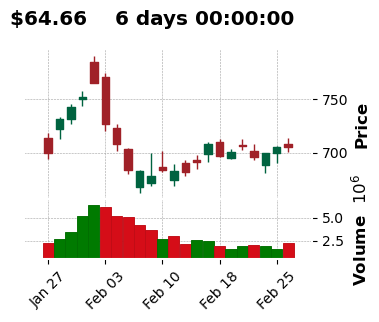

2016-01-22


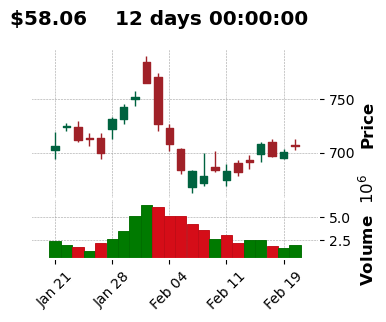

2016-01-14


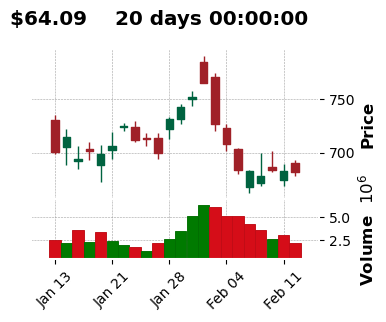

2015-12-16


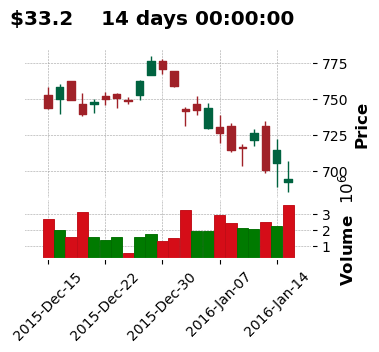

2015-12-01


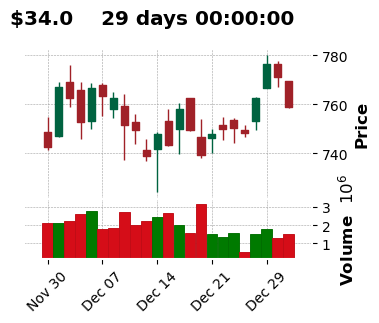

2015-11-20


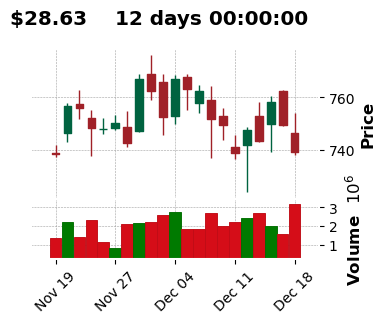

2015-11-18


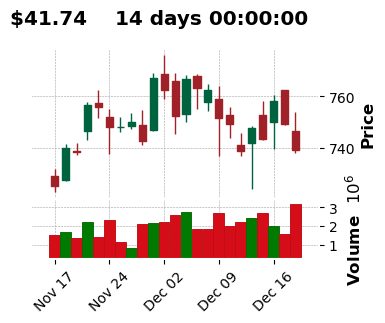

2015-10-23


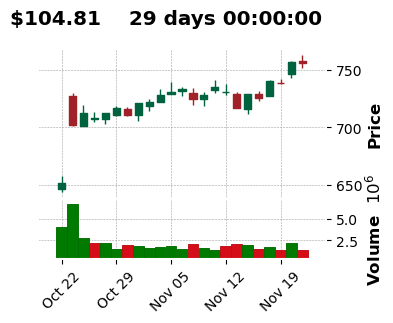

2015-10-05


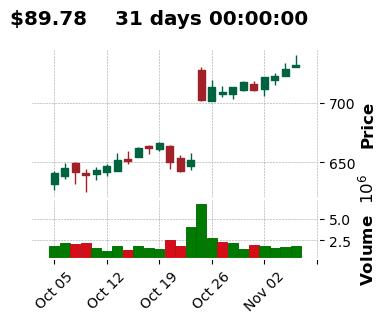

2015-10-02


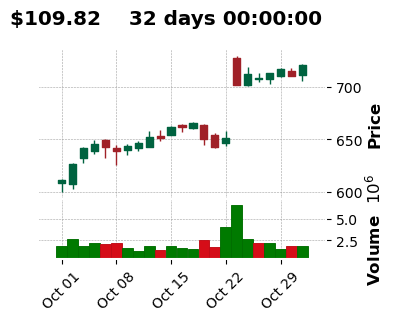

2015-09-30


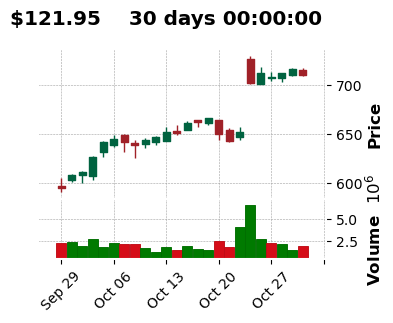

2015-09-15


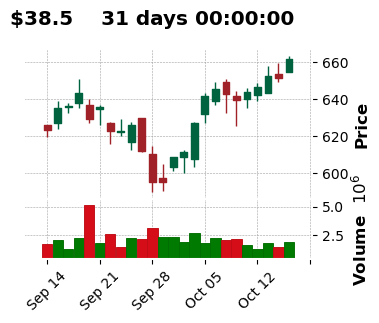

2015-09-08


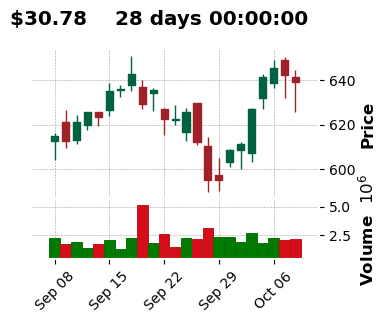

2015-09-02


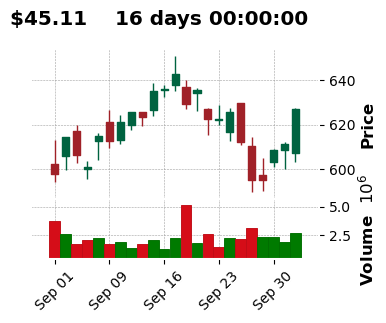

2015-08-26


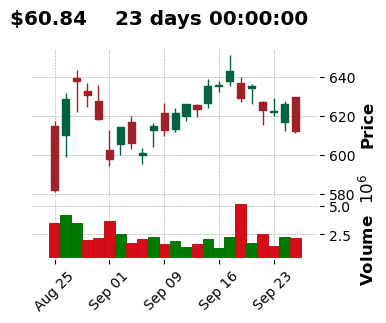

2015-08-11


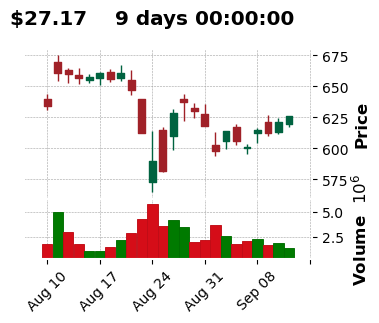

2015-08-05


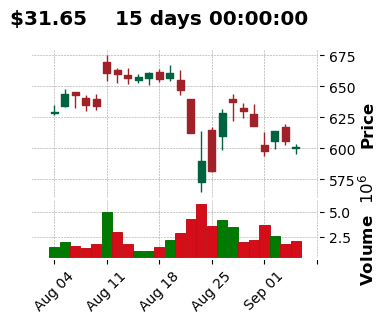

2015-07-17


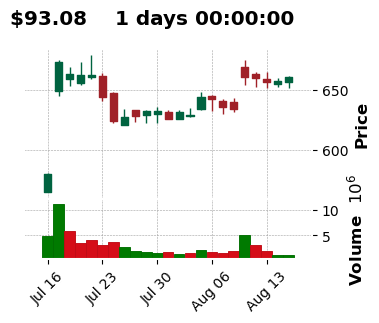

2015-07-16


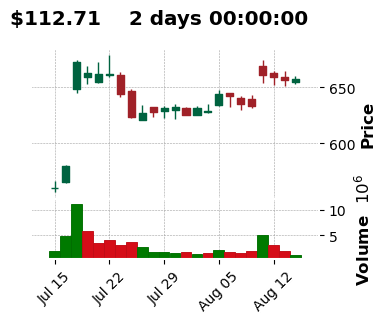

2015-07-14


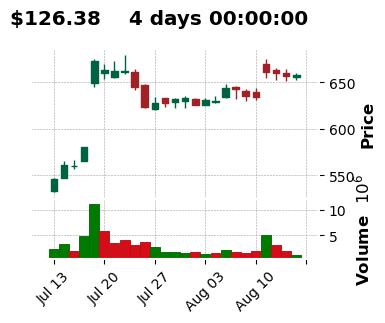

2015-07-13


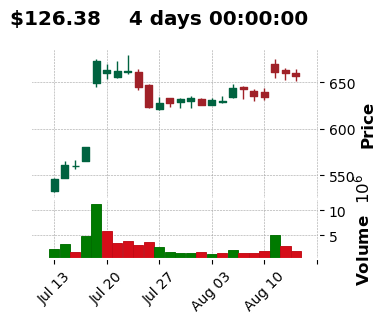

2015-04-24


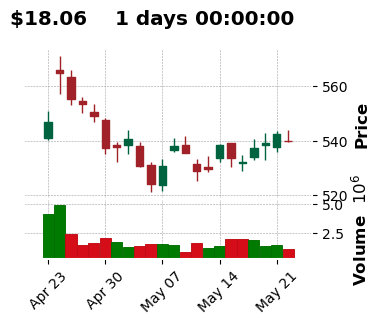

2015-04-20


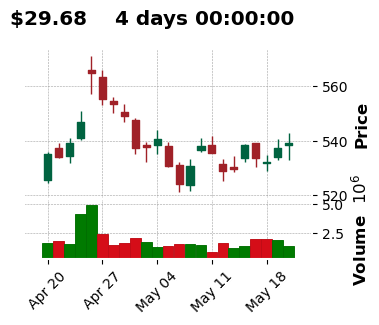

2015-03-24


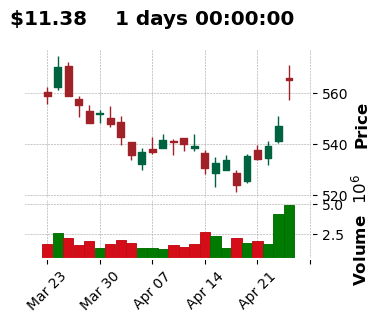

2015-03-02


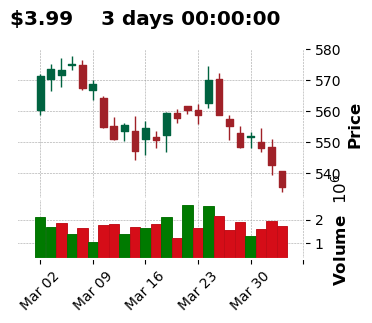

2015-02-26


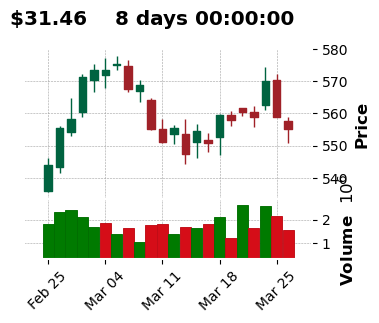

2015-01-30


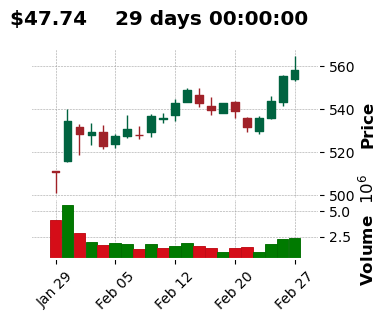

2015-01-22


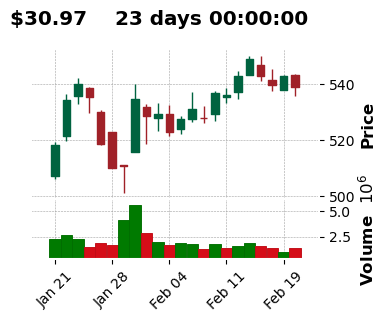

2015-01-21


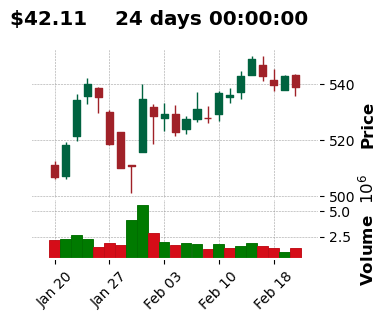

2014-12-17


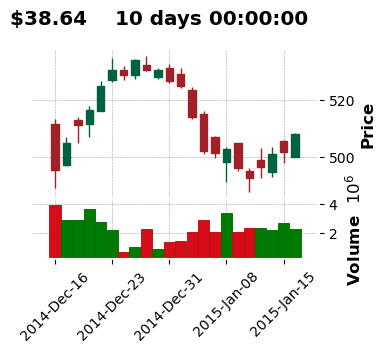

2014-10-23


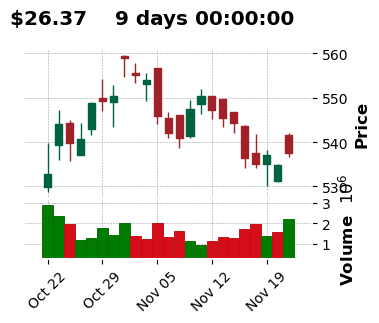

2014-08-13


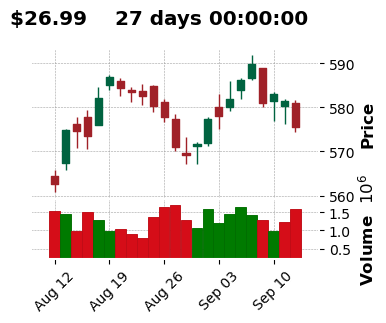

2014-07-18


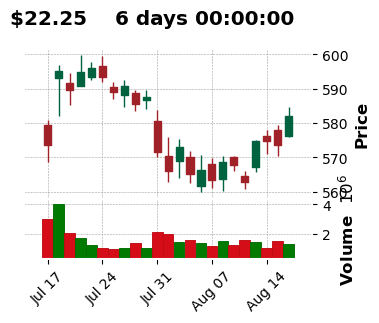

2014-06-25


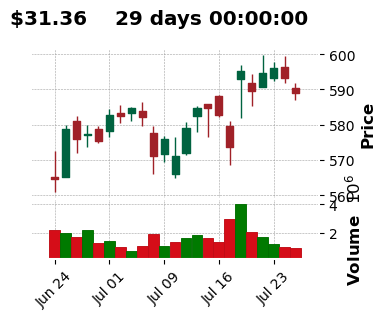

2014-06-18


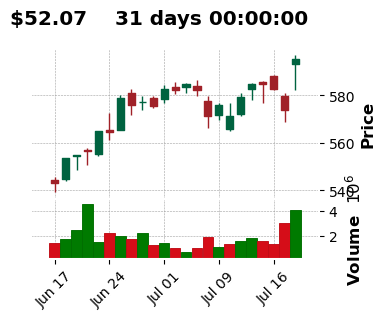

2014-05-27


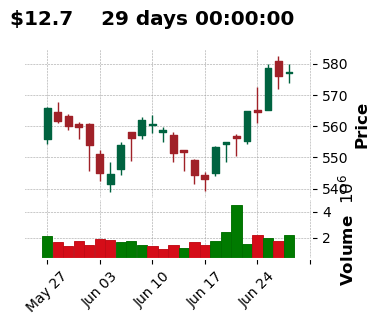

2014-05-12


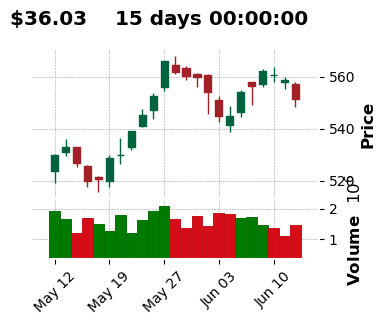

2014-04-29


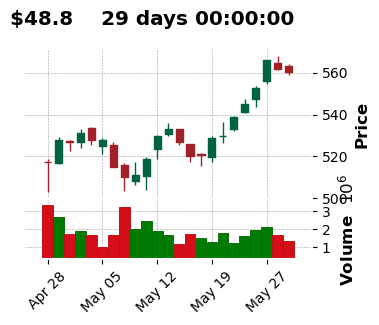

2014-04-16


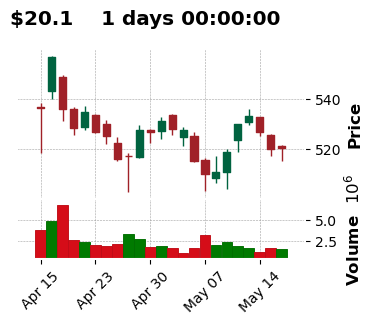

2014-04-08


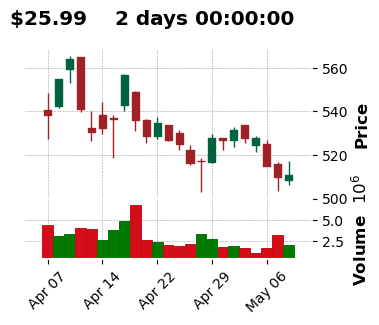

In [171]:
m = 1
def get_graphs(bl_list):
    list_len = len(bl_list)
    i = 0
    while i < list_len:
        start = bl_list[i]
        end = start + DateOffset(months = m)
        end = str(end)[0:10]
        day_before = start - DateOffset(days = 1)
        day_before = str(day_before)[0:10]
        row_zero = stock_df[stock_df['Date'].astype(str).str[:10] == day_before]
        start = str(start)[0:10]
        query = stock_df[(stock_df['Date'] >= (start)) & (stock_df['Date'] <= (end))] 
        query = query.reindex(index = query.index[::-1])
        query.reset_index(inplace = True, drop = True)
        df = pd.concat([row_zero, query], ignore_index=True)
        
        peak_num = df['Close'].max()
        min_num = df['Close'][0]
        gain = round(peak_num - min_num,2)

        initial_date = df.loc[df['Close']==peak_num]
        peak_date = []
        for stuff in initial_date['Date']:
            peak_date.append(stuff)
        begin_date = df['Date'].iloc[0]
        num_of_days = peak_date[0] - begin_date
                       
        df = df[['Open', 'High', 'Low', 'Close', 'Date', 'Volume' ]].set_index('Date')
        print(str(bl_list[i])[0:10])
        mpf.plot(df, type = 'candle', style = 'charles', volume = True, figsize = (4,3),
                 mav = (200), title = ('$'+str(gain)+ '    '+str(num_of_days)))
        i += 1
        
    
print('Historical Big Drops')        
get_graphs(bl_list)

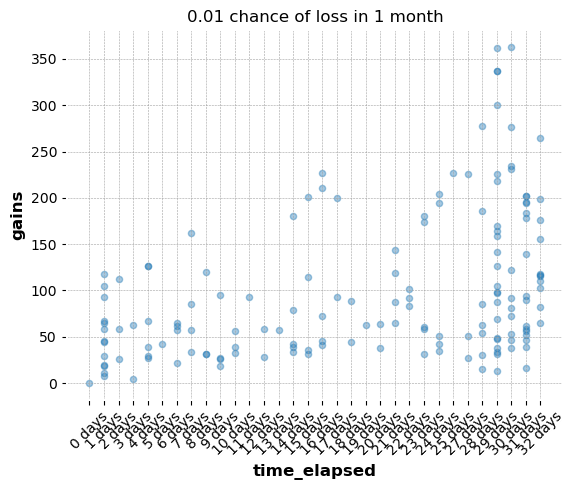

In [174]:
gain_list = []
date_list = []


def get_data(bl_list):
    list_len = len(bl_list)
    i = 0
    while i < list_len:
        start = bl_list[i]
        end = start + DateOffset(months = m)
        end = str(end)[0:10]
        day_before = start - DateOffset(days = 1)
        day_before = str(day_before)[0:10]
        row_zero = stock_df[stock_df['Date'].astype(str).str[:10] == day_before]
        start = str(start)[0:10]
        query = stock_df[(stock_df['Date'] >= (start)) & (stock_df['Date'] <= (end))] 
        query = query.reindex(index = query.index[::-1])
        query.reset_index(inplace = True, drop = True)
        df = pd.concat([row_zero, query], ignore_index=True)
        
        peak_num = df['Close'].max()
        min_num = df['Close'][0]
        gain = round(peak_num - min_num,2)
        gain_list.append(gain)

        initial_date = df.loc[df['Close']==peak_num]
        peak_date = []
        for stuff in initial_date['Date']:
            peak_date.append(stuff)
        begin_date = df['Date'].iloc[0]
        num_of_days = peak_date[0] - begin_date
        date_list.append(num_of_days)
        i +=1
    return(gain_list, date_list)
        
    
gain_list,date_list =get_data(bl_list)   

df_scat = pd.DataFrame(list(zip(gain_list, date_list)),
            columns = ['gains', 'time_elapsed'])

df_scat = df_scat.sort_values(by = ['time_elapsed'], ascending = True, ignore_index = True)
df_scat['time_elapsed'] = df_scat['time_elapsed'].astype(str)

zero_gains = df_scat.loc[df_scat['gains']==0.00]
loss_chance = str(round(len(zero_gains)/len(df_scat),2))+ ' chance of loss in '+str(m)+' month'
loss_chance

df_scat.plot.scatter(x = 'time_elapsed', y = 'gains', alpha = 0.4)
plt.title(loss_chance)
plt.xticks(rotation = 45);

In [ ]:
# classify the lower gains as losses.....

# Save Local CSV Copy for Database

In [ ]:
sym = sym.upper()
stock_df.to_csv(sym+'_df.csv', index = False, mode = 'a')

In [64]:
# integrate into blog, to create flat HTML in order to showcase. 